# Project II: Machine Learning the Ising Phase Transition
## Learning from data [TIF285], Chalmers, Fall 2019

#### Christian Forssén and Shahnawaz Ahmed, Chalmers
Last revised: 16-Oct-2019 by Christian Forssén [christian.forssen@chalmers.se]

## Instructions

- See deadline on the course web page
- This project is performed in groups of two students. 
- The second part of the project is optional and only gives extra points. See examination rules on the course web page.
- Hand-in your written report via Canvas.

### Written report
- Page limit: 6 pages (excluding title page and list of references). 3 extra pages are allowed when doing also the optional extra task.
- Give a short description of the nature of the problem and the methods you have used.
- Include your results either in figure form or in a table. All tables and figures should have relevant captions and labels on the axes.
- Try to give an interpretation of you results.
- Upload the source code of your program as a separate file (.ipynb or .py). Comment your program properly.

### Import modules

We need TensorFlow 2 for parts of this project. Make sure to update your `tif285-env` environment using the following command (making sure that you have the most recent version of the `environment.yml` file that includes `tensorflow` on the last line):

```
conda env update -f environment.yml
```

Please note that Keras has become a part of Tensorflow in the latest release. Therefore many of the online TensorFlow tutorials which use Keras can now directly use imports such as 

```
from tensorflow.keras.models import Sequential
```

instead of the earlier:

```
from keras.models import Sequential
```

In [1]:
%matplotlib inline

import os
import time
import pickle
from multiprocessing import Pool as ThreadPool

import numpy as np

from scipy.optimize import curve_fit
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D

from tqdm import tqdm

width = 6
height = width/1.5
fsize = 16
font = {'size': fsize}    
mpl.rc('font', **font)
mpl.rc('xtick', labelsize=fsize)
mpl.rc('ytick', labelsize=fsize)
mpl.rc('text', usetex=False)

np.random.seed(42)

## Background

The Ising model is arguably the most famous model in (condensed matter) physics. It is described by the simple Hamiltonian

$$
H=−J \sum_{\langle i,j \rangle} s_i s_j.
$$

Here, the $s_i=\{−1,1\}$ are classical, binary magnetic moments (spins) sitting on a two-dimensional square lattice and the $\langle i,j \rangle$ indicates that only interactions betweens neighboring spins are taken into account. For simplicity, we will set $J=1$.

Most importantly, the Ising model shows a phase transition between a paramagnetic and a ferromagnetic phase as a function of temperature. The critical temperature $T_c$ at which this change of magnetic character occurs has been calculated exactly by Lars Onsager. He found

$$
T_c = \frac{2}{\log \left( 1 + \sqrt{2} \right) }
$$

In [2]:
Tc = 2 / np.log(1+np.sqrt(2))
print(f"Critical temperature: Tc = {Tc:.4f}")

Critical temperature: Tc = 2.2692


In this project we aim to reproduce this result (ruffly) using increasingly sophisticated neural networks. You will use
1. a simple binary classifier (single neuron) that you implement yourself.
1. a relatively simple neural network (one hidden layer with 100 neurons) implemented using keras / tensorflow.
1. a convolutional neural network
1. (extra task) a Bayesian neural network

At the end, the results that you obtain made it all the way into a Nature Physics publication just a few years ago: [Nature Physics (2017) 13, 431–434](https://www.nature.com/articles/nphys4035)

We will start by quickly simulating the Ising model using the Monte Carlo method to obtain representative sets of spin configurations for a bunch of temperatures. Afterwards, we do not take the traditional approach of inspecting the magnetization, the order parameter of the transition, and its susceptibility. Instead we use supervised learning to train a Neural Network to automagically learn the transition temperature.

### Monte Carlo simulation
The Monte Carlo method for the Ising model is very straightforward: take a random configuration of spins to begin with and propose individual spin flips until you fall asleep. To decide whether a spin should be flipped we use the Metropolis criterium
$$
p=\min \left( 1, e^{-\beta\Delta E} \right)
$$
where $\Delta E = E′−E$ is the energy difference between the new (spin flipped) and the old configuration according to $H$ above and $\beta = 1/T$ is the inverse of the temperature $T$. Since $\Delta E$ only depends on the local environment of the spin to be flipped (nearest neighbors), we can evaluate it locally. 

## Generate spin configurations and study the phase transition

In the python file attached with this notebook we have the definition of a `Lattice` class which can be used to generate a 2D lattice for `N` spins at a temperature `T`. Here, we simply import the `Lattice` class and use the `step` method to generate a lattice after a few hundred iterations to simulate a thermalization of the lattice. 

At every iteration, we select $N^2$ random points to try a flip attempt. A flip attempt consists of checking the change in energy due to a flip. If it is negative or less than $e^{-E/(k_b T)}$, then perform the flip. After a few steps the lattice with thermalize.



#### *You need the `lattice.py` file in the same directory to get this to work which contains the definition of `Lattice`*


In [3]:
from lattice import Lattice

In [4]:
# Initialize a lattice
lat = Lattice(N=10, T=4.5)

# Make 30 iterations (N**2 spin flip attempts)
for i in range(30):
    lat.step()

print(lat.lattice) # (or even `print lat` to use the convenient repr)

[[ 1  1  1  1 -1 -1 -1 -1 -1  1]
 [ 1  1  1  1  1  1 -1 -1 -1  1]
 [ 1  1  1 -1 -1 -1  1 -1 -1  1]
 [ 1  1  1 -1  1  1  1  1 -1  1]
 [ 1  1  1  1  1 -1  1  1 -1 -1]
 [ 1  1  1 -1 -1  1 -1  1  1 -1]
 [ 1  1 -1 -1 -1 -1 -1  1 -1 -1]
 [ 1  1  1  1 -1 -1  1 -1  1  1]
 [ 1 -1  1  1  1  1 -1 -1  1  1]
 [ 1  1  1  1 -1  1  1  1  1  1]]


### Illustrate some spin configurations, and plot macroscopic quantities as a function of temperature

6it [00:07,  1.19s/it]


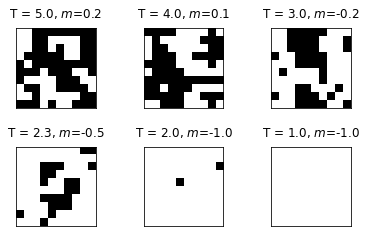

In [5]:
# 10 x 10 lattice
# six temperatures, 500 thermalization iterations
# Plot the spin configurations for varying temperatures.
# Display the magnetization too

nrows, ncols = 2, 3
fig, axs = plt.subplots(nrows, ncols)
fig.subplots_adjust(wspace=0.6)

for (ip, T) in tqdm(enumerate([5.0, 4.0, 3.0, 2.3, 2.0, 1.0])):
    lat = Lattice(N=10,T=T)
    for k in range(500):
        lat.step()

    idx = ip // ncols, ip % ncols

    axs[idx].matshow(lat.lattice,cmap=plt.cm.gray_r)
    axs[idx].set_title(f"T = {T:.1f}, $m$={lat.get_avg_magnetization():.1f}")

    axs[idx].get_xaxis().set_visible(False)
    axs[idx].get_yaxis().set_visible(False)

In [6]:
### load data from file instead of generating it anew each time ###
load_from_file = True

if load_from_file:
    points = np.loadtxt('points.txt')
    points_full = np.loadtxt('points_full.txt')
else:
    # 10 x 10 lattice
    # 60 temperatures, 500 thermalization iterations

    # For a temperature range, thermalize a lattice, then
    # take a few hundred steps, recording energy and magnetization.
    # Store the means to plot next.
    # This takes about 60s with one modern core.

    # Thermalization and measurement steps
    ntherm = 500
    nmeasure = 200

    # points = array with (T, mean(E), abs(mean(M)), var(E))
    # with the mean and variance evaluated for a list of many temperatures
    points = []
    # Storing nmeasure / nsparse data points
    nsparse = 10
    # points_full = array with (T, E, abs(M))
    # for several different configurations per temperature
    points_full=[]
    for T in tqdm(np.arange(4.0,1.0,-0.05)):
        lat = Lattice(N=10,T=T)
        for _ in range(ntherm):
            lat.step()
        Es = []
        Ms = []

        for istep in range(nmeasure): 
            lat.step()
            Es.append(lat.get_energy())
            Ms.append(lat.get_avg_magnetization())
            if (istep%nsparse==0):
                points_full.append((T,Es[-1],np.abs(Ms[-1])))           
        Es = np.array(Es)
        Ms = np.array(Ms)
        points.append((T,Es.mean(),np.abs(Ms.mean()),Es.var()))
    points = np.array(points)
    points_full = np.array(points_full)


In [7]:
### save data so that we don't have to run this each time ###
if not load_from_file:
    np.savetxt('points.txt', points)
    np.savetxt('points_full.txt', points_full)

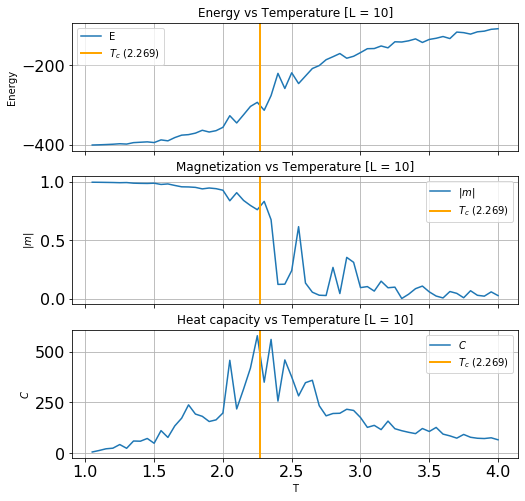

In [8]:
### Plot the energy, magnetization, and heat capacity vs temperature ###

fig, axs = plt.subplots(3,1,sharex=True,figsize=(8,8))

axs[0].plot(points[:,0],points[:,1], label="E")
axs[0].set_ylabel("Energy")
axs[0].set_title("Energy vs Temperature [L = 10]")

axs[1].plot(points[:,0],points[:,2], label="$|m|$")
axs[1].set_ylabel("$|m|$")
axs[1].set_title("Magnetization vs Temperature [L = 10]")

# heat capacity
# C = var(E) / ( k_B T**2)
heat_capacity = points[:,3] / (points[:,0]**2)
axs[2].plot(points[:,0],heat_capacity, label="$C$")
axs[2].set_xlabel("T")
axs[2].set_ylabel("$C$")
axs[2].set_title("Heat capacity vs Temperature [L = 10]")

for ax in axs:
    ax.axvline(x=Tc,linestyle='-', color="orange",linewidth=2.0, label="$T_c$ ({:.3f})".format(Tc))
    ax.legend(loc="best", numpoints=1)
    ax.grid(True)

### Energy vs magnetization
Blue data is low temperature ($<T_c$) and red data is high temperature ($>T_c$).

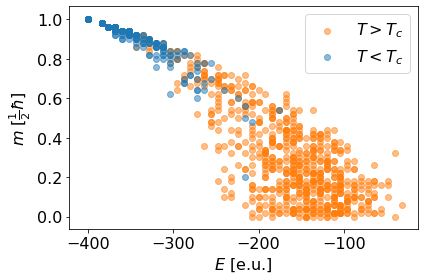

In [9]:
### plot low & high data in E-m-plot ###
high_T = points_full[:,0]>Tc
low_T = points_full[:,0]<Tc

E_M_high = points_full[high_T][:,1:]
E_M_low = points_full[low_T][:,1:]

fig, ax = plt.subplots(1,1)
ax.scatter(E_M_high[:,0], E_M_high[:,1], c='C1', label=r'$T > T_c$', alpha=0.5)
ax.scatter(E_M_low[:,0], E_M_low[:,1], c='C0', label=r'$T < T_c$', alpha=0.5)
ax.set_xlabel(r'$E$ [e.u.]', fontsize=fsize)
ax.set_ylabel(r'$m$ [$\frac{1}{2} \hbar$]', fontsize=fsize)

plt.legend(fontsize=fsize)
plt.tight_layout()
plt.savefig('complete_data_set.pdf')
plt.show()

## Task 1: Single neuron binary classifier

Create a binary classifier that can take $(E,|m|)$ as input data and predict a binary label (0=below Tc, 1=above Tc).

Hints:
* Build your own binary classifier from a single neuron. Study the lecture notes and the exercise on logistic regression / neural networks.
* Normalize the data before training / testing (mean=0, standard deviation=1).
* Split into 70 % training data and 30% test data.
* Use weight decay alpha=1.0, learning parameter eta=0.01
* A rather large number of training iterations will be needed.

**How well does it perform? Plot the decision boundary.**

In [10]:
### split data into training & validation ###
inputs = np.append(E_M_low, E_M_high, axis=0)
labels = np.append(np.zeros_like(E_M_low[:,0]), np.ones_like(E_M_high[:,0]), axis=0)

train_size = 0.7
X_train, X_test, Y_train, Y_test = train_test_split(inputs, labels, train_size=train_size)

### normalize data ###
mean = np.mean(X_train, axis=0)
std = np.sqrt(np.var(X_train, axis=0))
X_train_normalized = (X_train - mean) / std
X_test_normalized = (X_test - mean) / std

In [11]:
### define forward pass & back propagation ###
def f(z):
    """
    Sigmoid activation function.
    """
    return 1 / (1 + np.exp(-z))

def sn_feed_forward(X):
    """
    Feed-forward pass.
    Uses sn_weights, sn_bias
    
    Args:
        X (array[float]): input to the neural network

    Returns:
        prob (float): probability of high
    """
    z = bias_sn + X @ weight_sn 
    prob = f(z)
    
    return prob

def predict(X):
    """
    Return a prediction by finding the class with the highest likelihood.

    Args:
        X (array[float]): input to the neural network

    Returns:
        label (integer): index of the category with the highest probability, 0 or 1
    """
    prob = sn_feed_forward(X)
    
    return np.round(prob)
    
def backpropagation(X, Y):
    prob = sn_feed_forward(X)
    error_output = prob.T - Y
    dCdW = error_output @ X
    dCdb = error_output.sum()
    
    return dCdb, dCdW.T

Accuracy on training data: 0.9560
Accuracy on test data: 0.9472


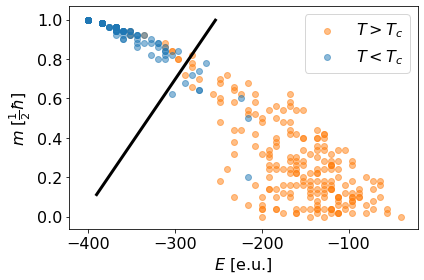

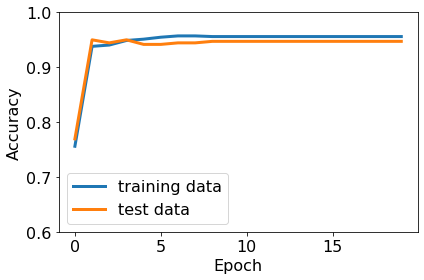

In [12]:
### define learning parameters ###
alpha = 1.0 # regularizer
eta = 0.01 # step size
iters = 20 # a rather large number

### initiate some vectors ###
weight_sn = np.random.rand(2)[:,None]
bias_sn = 0.01
weights = np.zeros((iters,3))
accuracies = np.zeros(iters)
accuracies_val = np.zeros(iters)

### train classifier ###
for i in range(iters):
    ### save data from each iteration for later ###
    weights[i,0] = bias_sn
    weights[i,1] = weight_sn[0]
    weights[i,2] = weight_sn[1]
    accuracies[i] = accuracy_score(predict(X_train_normalized), Y_train)
    accuracies_val[i] = accuracy_score(predict(X_test_normalized), Y_test)
    
    ### update weights ###
    dCdb, dCdW = backpropagation(X_train_normalized, Y_train)
    bias_sn -= eta * (dCdb + alpha * bias_sn)
    weight_sn -= eta * (dCdW + alpha * weight_sn)

### extract best fit from classifier ###
E = np.linspace(-1.2, 0.)
m = -bias_sn / weight_sn[1] - weight_sn[0] / weight_sn[1] * E
E = E * std[0] + mean[0]
m = m * std[1] + mean[1]

### plot (unnormalized) results ###
plotting_test_data = True # defaults to plotting training data
print(f"Accuracy on training data: {accuracy_score(predict(X_train_normalized), Y_train):.4f}")
print(f"Accuracy on test data: {accuracy_score(predict(X_test_normalized), Y_test):.4f}")

fig, ax = plt.subplots()
ax.plot(E, m, color='k', linewidth=3.0, label=r'')
if plotting_test_data:
    ax.scatter(X_test[Y_test==1][:,0], X_test[Y_test==1][:,1], color='C1', label=r'$T > T_c$', alpha=0.5)
    ax.scatter(X_test[Y_test==0][:,0], X_test[Y_test==0][:,1], color='C0', label=r'$T < T_c$', alpha=0.5)
else:
    ax.scatter(X_train[Y_train==1][:,0], X_train[Y_test==1][:,1], color='C1', label=r'$T > T_c$')
    ax.scatter(X_train[Y_train==0][:,0], X_train[Y_test==0][:,1], color='C0', label=r'$T < T_c$')
ax.set_xlabel(r'$E$ [e.u.]', fontsize=fsize)
ax.set_ylabel(r'$m$ [$\frac{1}{2} \hbar$]', fontsize=fsize)
#ax.set_title('Data & best fit', fontsize=fsize) # Christian is a bit against titles on figures

plt.legend(fontsize=fsize)
plt.tight_layout()
plt.savefig('single_neuron_decision_boundary.pdf')
plt.show()

### plot model performance
fig, ax = plt.subplots()
ax.plot(accuracies, label='training data', linewidth=3.0)
ax.plot(accuracies_val, label='test data', linewidth=3.0)
ax.set_xlabel('Epoch', fontsize=fsize)
ax.set_ylabel('Accuracy', fontsize=fsize)
ax.set_ylim(bottom=0.6, top=1.)

plt.legend(fontsize=fsize)
plt.tight_layout()
plt.savefig('single_neuron_performance.pdf')
plt.show()

## Neural network classifiers based on spin configurations

You should now use a neural network to learn the phase transition based on images of the spin configurations.
We will use special tricks to generate new data for free from the configurations that we have generated (e.g. by flipping all spins, and by mirroring).

### Generate spin configurations

In [13]:
# Use 6 threads to run some lattice evolutions
# With current parameters, this took a minute or two on an i7
# Dump out the lattice configurations/temperatures to a file
# and just load it if the file already exists, since this
# is a CPU intensive cell.

fname = "ising_config_data_big.pkl"

def get_lattices(T, N=10, Nlattices=25, Nthermal=200):
    """
    Generates a set of lattices at a given temperature
    
    Args:
        T (float): temperature of the lattice
        N (int): the lattice size
        Nlattices (int): the number of lattices to generate
        Nthermal (int): the number of steps to simulate thermalization
    """
    lattices = []
    for _ in range(Nlattices):
        lat = Lattice(N=N,T=T)
        for _ in range(Nthermal):
            lat.step()
        lattices.append(lat.lattice)
    return round(T, 4), lattices

if not os.path.exists(fname):
    pool = ThreadPool(6)
    Ts = np.arange(5.0,1.0,-0.1)
    d_data = {}
    for T, lattices in pool.imap_unordered(get_lattices, Ts):
        print(T)
        d_data[T] = lattices

    with open(fname,"wb") as fhout:
        pickle.dump(d_data,fhout)
    print(f">>> Dumped to {fname}")

else:
    d_data = pickle.load(open(fname,"rb"))
    print(">>> Loaded from {}".format(str(fname)))

>>> Loaded from ising_config_data_big.pkl


In [14]:
# make vector of input matrices, vector of temperatures
X_data = []
y_data = []
T_data = []

for T,configs in d_data.items():
    for config in configs:
        # flip spins to double dataset keeping E same
        # this is also needed so ML algorithm doesn't learn
        # to prefer one magnetization sign over another
        # also make truth labels (0 is low T phase, 1 is high T phase)
        # and also mirror lattice horizontally/vertically to get free data
        target = 0
        if T > Tc:
            target = 1
            
        X_data.append(config)
        X_data.append(np.flip(config,0))
        X_data.append(np.flip(config,1))
        X_data.append(-config)
        X_data.append(-np.flip(config,0))
        X_data.append(-np.flip(config,1))
        
        for _ in range(6):
            T_data.append(T)
            y_data.append(target)


X_data = np.array(X_data)
y_data = np.array(y_data)
T_data = np.array(T_data)

# convert spin matrices from -1,1 to 0,1
X_data = 0.5*(X_data+1)

# Thus, our training and test sets will consist of 
# the lattice images and the targets will be 0 or 1.
# If the lattice is at low (T<Tc) or high (T>Tc) temperature
# It's up to the NN / CNN to learn the concept of temperature/magnetization/etc.

We implement two different ways to split our data in training and test sets:

1. Randomly
1. Using only spin configurations at very high and very low temperatures as training data

In the second approach our ultimate goal will be to see if we can correctly predict the phase for all intermediate temperatures. 

In [15]:
# function to split the data
def split_data(X_data, y_data, T_data, Thi=4.7, Tlo=1.3, test_size=0,random_state=42):
    """
    Splits the data into train and test sets according to the settings.
    
    Either using sklearn train_test_split (test_size).  
    Or, alternatively, using T>Thi and T<Tlo data as training data and Tlo < T < Thi as predictions/test.
    """
    if test_size:
        print(f"Using sklearn to split data. Test size: {test_size*100:}%")
        X_train, X_test, y_train, y_test, T_train, T_test = \
          train_test_split(X_data, y_data, T_data, test_size=test_size, random_state=random_state)
    elif (Thi and Tlo):
        print(f"Using T>{Thi} and T<{Tlo} as training data.")
        train_set = np.logical_or(T_data>=Thi,T_data<=Tlo)
        test_set = np.logical_not(train_set)
        X_train = X_data[train_set]
        X_test = X_data[test_set]
        y_train = y_data[train_set]
        y_test = y_data[test_set]
        T_train = T_data[train_set]
        T_test = T_data[test_set]
    else:
        print("No rule to split data.")
        return None
        
    print(f"...Training samples: {X_train.shape[0]}")
    print(f"...Testing samples:  {X_test.shape[0]}")
    return(X_train, X_test, y_train, y_test, T_train, T_test)

## Task 2: Tensorflow neural network with a single hidden layer

1. Implement a neural network with a single hidden layer using tensorflow.
1. Flatten the 10x10 input images into arrays of length 100.
1. Use random splitting of the data (70% for training)

Study in particular:
* What is the accuracy of predictions on the training / test data?
* Try to predict the critical temperature

*Hint*: Plot the average predictions for lattices in the test set at different temperatures. The point at which the prediction passes through 0.5 is the critical temperature. I.e., at a phase transition, the CNN is confused about what phase the system is in. So we fit a sigmoid to the points and use this to estimate the crossing point (`Tc_fit`)

In [63]:
x_train, x_test, y_train, y_test, T_train, T_test = split_data(X_data, y_data, T_data, test_size=0.3)

Using sklearn to split data. Test size: 30.0%
...Training samples: 4200
...Testing samples:  1800


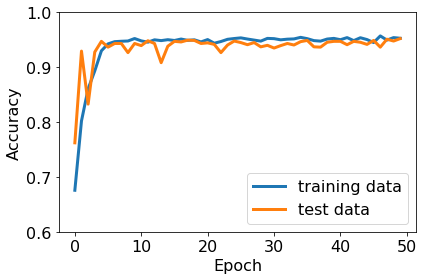

In [64]:
### define & run nn ###
nn = Sequential([
    Flatten(input_shape=(10, 10)),
    Dropout(0.05),
    Dense(50, activation='relu', kernel_regularizer=keras.regularizers.l2(1e-2)),
    Dense(1, activation='sigmoid')
])

nn.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
hist = nn.fit(x=x_train, y=y_train, validation_data=(x_test, y_test), epochs=50, verbose=0)

### plot learning rates ###
fig, ax = plt.subplots()
ax.plot(hist.history['accuracy'], label=r'training data', linewidth=3.0)
ax.plot(hist.history['val_accuracy'], label=r'test data', linewidth=3.0)
ax.set_xlabel(r'Epoch', fontsize=fsize)
ax.set_ylabel(r'Accuracy', fontsize=fsize)
ax.set_ylim(bottom=0.6, top=1.)

plt.legend(fontsize=fsize)
plt.tight_layout()
plt.savefig('dnn_perfomance.pdf')
plt.show()

In [65]:
### evaluate nn ###
train_loss, train_acc = nn.evaluate(x_train,  y_train, verbose=0)
test_loss, test_acc = nn.evaluate(x_test,  y_test, verbose=0)
print('train accuracy:', train_acc)
print('test accuracy:', test_acc)

train accuracy: 0.96809524
test accuracy: 0.9522222


Critical temperature = 2.30946 [Kevin]


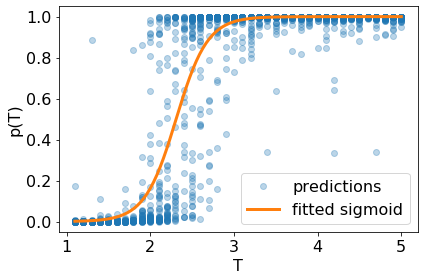

In [19]:
### fit sigmoid function to data ###
def sigmoid(x, a, b):
    return 1. / (1. + np.exp(a * (x + b))) # b is defined as the p=0.5 point, so we just extract this

y_pred = nn.predict(x_test)
(a, b), pcov = curve_fit(sigmoid, T_test, y_pred[:,0], p0=(1., -2.))
print(f"Critical temperature = {-b:.6} [Kevin]")

### plot data w/ sigmoid fit ###
fig, ax = plt.subplots()
ax.plot(T_test, y_pred, 'o', alpha=0.3, label=r'predictions')
T_span = np.linspace(np.min(T_test), np.max(T_test), num=200)
ax.plot(T_span, sigmoid(T_span, a, b), label=r'fitted sigmoid', linewidth=3.0)
ax.set_title(r'', fontsize=fsize)
ax.set_xlabel(r'T', fontsize=fsize)
ax.set_ylabel(r'p(T)', fontsize=fsize)

plt.legend(fontsize=fsize)
plt.tight_layout()
plt.savefig('dnn_sigmoid_fit.pdf')
plt.show()

### A note about the output encoding, loss function and number of outputs

If you check the target `y_train`, you notice that we have an `array([0, 1, 1, ..., 0, 0, 1])` representing the phases. This represents a binary classification problem where we expect the output of the final layer of the network to give a 1/0 output. In particular, if the final neuron has a sigmoid activation, it will give outputs very close to 0/1 as `array([0.01, 0.99, 0.95, ..., 0.2, 0.1, 0.86])`.

While this works for a binary classification problem, if you have more than two classes as output, e.g., {"red", "green", "yellow"}, this simple 1/0 encoding does not work and you need to have a one-hot encoding:

red = [1, 0, 0]
green = [0, 1, 0]
yellow = [0, 0, 1]

In this case, think about how many neurons you should have in your output layer. You need to be also careful about the loss function you choose in this case.

#### One hot encoding with keras

If you do choose a one-hot encoding then you can use the following functionality in `keras`

```
keras.utils.to_categorical(y_train, 2)
```

where the 2 represents that you have two classes in your y_train.

In [67]:
y_train = keras.utils.to_categorical(y_train, 2)
y_test = keras.utils.to_categorical(y_test, 2)

## Task 3: Convolutional neural network (CNN) 
Now use a convolutional neural network (CNN) instead. Those are optimal for working with images.

1. Implement a CNN with several hidden layers using tensorflow.
1. Now we will use only low- and high-temperature configurations as training data.

Study in particular:
* What is the accuracy of predictions on the training / test data?
* Try to predict the critical temperature


In [68]:
print(X_data.shape,y_data.shape,T_data.shape)
print(X_train.shape,y_train.shape,T_train.shape)

(6000, 10, 10) (6000,) (6000,)
(1050, 10, 10) (4200, 2) (4200,)


In [81]:
X_train, X_test, Y_train, Y_test, T_train, T_test = split_data(X_data, y_data, T_data, Thi=4.7, Tlo=1.3)

Using T>4.7 and T<1.3 as training data.
...Training samples: 1050
...Testing samples:  4950


In [82]:
# prepare for CNN input
img_rows, img_cols = 10, 10
x_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
x_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)

input_shape = (img_rows, img_cols, 1)

y_train = keras.utils.to_categorical(Y_train, 2)
y_test = keras.utils.to_categorical(Y_test, 2)

In [83]:
### define CNN ###
cnn = Sequential([
    Conv2D(10, (3, 3), activation='relu', input_shape=(10,10,1), kernel_regularizer=keras.regularizers.l2(5e-2)),
    MaxPooling2D((2, 2)),
    Dropout(0.05),
    Conv2D(10, (3, 3), activation='relu', kernel_regularizer=keras.regularizers.l2(5e-2)),
    MaxPooling2D((2, 2)),
    Dropout(0.05),
    Flatten(),
    Dense(10, activation='relu', kernel_regularizer=keras.regularizers.l2(5e-2)),
    Dense(2, activation='sigmoid')
])

### train CNN ###
cnn.summary() # print some info about our CNN
cnn.compile(optimizer='adam',
            loss='categorical_crossentropy',
            metrics=['accuracy'])
fit = cnn.fit(x_train, y_train, batch_size=100, epochs=200, validation_data=(x_test, y_test), verbose=0)

Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_44 (Conv2D)           (None, 8, 8, 10)          100       
_________________________________________________________________
max_pooling2d_44 (MaxPooling (None, 4, 4, 10)          0         
_________________________________________________________________
dropout_46 (Dropout)         (None, 4, 4, 10)          0         
_________________________________________________________________
conv2d_45 (Conv2D)           (None, 2, 2, 10)          910       
_________________________________________________________________
max_pooling2d_45 (MaxPooling (None, 1, 1, 10)          0         
_________________________________________________________________
dropout_47 (Dropout)         (None, 1, 1, 10)          0         
_________________________________________________________________
flatten_24 (Flatten)         (None, 10)              

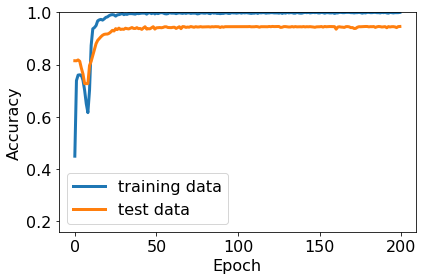

accuracy on training data: 1.0000
accuracy on test data: 0.9461


In [84]:
### plot CNN performance ###
fig, ax = plt.subplots()
ax.plot(fit.history['accuracy'], label='training data', linewidth=3.0)
ax.plot(fit.history['val_accuracy'], label = 'test data', linewidth=3.0)
ax.set_xlabel('Epoch', fontsize=fsize)
ax.set_ylabel('Accuracy', fontsize=fsize)
ax.set_ylim(bottom=0.16, top=1.)

plt.legend(fontsize=fsize)
plt.tight_layout()
plt.savefig('cnn_performance.pdf')
plt.show()

### print cnn accuracy ###
_, train_acc = cnn.evaluate(x_train, y_train, verbose=0)
_, test_acc = cnn.evaluate(x_test, y_test, verbose=0)
print(f'accuracy on training data: {train_acc:.4f}')
print(f'accuracy on test data: {test_acc:.4f}')

Critical temperature = 2.302311 [Kevin]


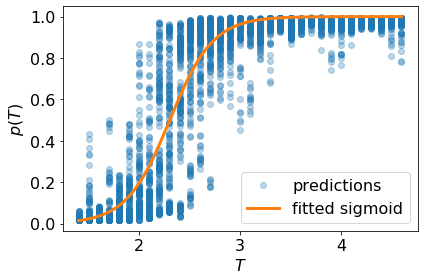

In [85]:
### fit sigmoid function to data ###
def sigmoid(x, a, b):
    return 1. / (1. + np.exp(a * (x + b))) # b is defined as th p=0.5 point, so we just extract this

y_pred = cnn.predict(x_test)
probs = (y_pred[:,1]) / (y_pred[:,0] + y_pred[:,1])
(a, b), pcov = curve_fit(sigmoid, T_test, probs, p0=(1., -2.))
print(f"Critical temperature = {-b:.8} [Kevin]")

### plot data w/ sigmoid fit ###
fig, ax = plt.subplots()
ax.plot(T_test, probs, 'o', alpha=0.3, label=r'predictions')
T_span = np.linspace(np.min(T_test), np.max(T_test), num=200)
ax.plot(T_span, sigmoid(T_span, a, b), label=r'fitted sigmoid', linewidth=3.0)
ax.set_title(r'', fontsize=fsize)
ax.set_xlabel(r'$T$', fontsize=fsize)
ax.set_ylabel(r'$p(T)$', fontsize=fsize)

plt.legend(fontsize=fsize)
plt.tight_layout()
plt.savefig('cnn_sigmoid_fit.pdf')
plt.show()

## Task 4: Understanding the neural network (extra)
Description to be added.

## Task 5: A simple Bayesian neural network (extra)
Description to be added.